# model02rp
### Un altro passo: arrivano le banche!
#### Sempre in azione l'*Istituto Centrale di Statistica* con a fianco la *Banca d'Italia*

use it in [Notebook viewer](https://nbviewer.org/github/terna/ejmmp/blob/main/model02/model02rp.ipynb) or explore it in [GitHub](https://github.com/terna/ejmmp/tree/main/model02) (with the tools.py and metaActions.py files)

to force the updatem if missing, follow once [Notebook viewer and flush cache](https://nbviewer.org/github/terna/ejmmp/blob/main/model02/model02rp.ipynb?flush_cache=true)

[Wikipedia as a memo](https://en.wikipedia.org/wiki/Stock-flow_consistent_model#cite_note-42)

In [1]:
%%javascript
// to avoid scroll in windows
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import random as r
import matplotlib.pyplot as plt
import commonVar as cmv
import numpy as np
from tools import *
from metaActions import *
from generateSeeds import *
from plot import *
import sys

### Stock-flow *model02*, with real and financial elements

- The model also considers the monetary side of the economy.

  

- We have to initialize loans and capital stocks.

  

- Currently, entrepreneurs have unlimited funds that they put freely in their activities, balancing other agent negative cash, if any.

  

- Saving is abstension from consuming, increasing agents' liquidity.



- Investments are uniquely for replacement, without technical progress.

  

### symbol table

[symbol table](https://oeis.org/wiki/List_of_LaTeX_mathematical_symbols) in $\LaTeX$

$a_i$ -  with $a_i \in \mathbf{A}$; agent number $N=|\mathbf{A}|$, `agentList` and`agentNum`

$a^e_i$ -  with $a^e_i \in \mathbf{A^e}$ and $\mathbf{A^e} \subset \mathbf{A}$; employer number $N^e=|\mathbf{A^e}|$ in range $[N^e_{min},N^e_{max}]$, `employerList`

$\mathbf{F}$ - firms' set, with $f_j \in \mathbf{F}$ being $N^f = |\mathbf{F}|$,  with $N^f = |\mathbf{F}| = |\mathbf{A^e}|$ , `firmList`

$\mathbf{A}^w$ - working agents' set, being $\mathbf{A}^w \subseteq \mathbf{A}$, with $N^w_i=|\mathbf{A}^w_i|$ number of working agents employed by employer $i$, also including self-employed employers, with $a_i \in \mathbf{A}^e$

$\mathbf{B}$ - banks' set, with $b_j \in \mathbf{B}$ being $N^b = |\mathbf{B}|$, `bankList`

$x^d$ - interest rate on deposits, `interestRateOnDeposits`

$x^{l^a}$ - interest rate on loans to (private) agents, `interestRateOnLoansVsAgents`

$x^{l^f}$ - interest rate on loans to firms, `interestRateOnLoansVsFirms`

$X^d_{a|f|b}$ - amount of positive interest on deposits for a given interval $t$ for agents $a$ or firms $f$, and negative for banks $b$, `interestOnDeposits`

$X^l_{a|f|b}$ - amount of negative interest on loans for a given interval $t$ for agents $a$ or firms $f$, and positive for banks $b$, `interestOnLoans`

$p$ - price `price`

$u$ - unemployment rate `unemploymentRate`

$dimensional~heterogeneity$ is a $true/false$ chooser, forcing increasing firms to attract more workers. `dimensionalHeterogeneity`

$\pi_{i,t}$ - labor productivity, a uniformly distributed decimal number in range $[\pi_{min},\pi_{max}]$,`productivity`

&Delta;$\pi_{i,t}$ - uniperiodal additive productivity correction in range $[$&Delta;$\pi_{min},$ &Delta;$\pi_{max}]$, `productivityDelta`

$n_{i,t}$ - number of workers in a firm

$q_{i,t}$ - production in quantity, `production`

$\Pi_{i,t}$ - profit, `profit`

$\rho$ - profit distribution share, `rho`

$\delta_{i,t}$ - dividend $\rho\Pi_{i,t}$, `dividend` or `perceivedDividend` 

$W$ - wage `wage`

$R_{i,t}$ - revenues, `revenues`

$s_{i,t}$ - sales in quantity, `sales`

$v_{i,t}$ - in**v**entories (final, initial), `initialInventories`, `finalInventories`

$d_{i}$ - deperibility share of the production, `deperibilityShare`, setting $d_{max}$

$c_{i,t}$ - consumption rate, a uniformly distributed decimal number in range $[c_{min},c_{max}]$,`consumptionRate`

$C_{i,t}$ - consumption of $i$ in $t$

$I_{i,t}$  - investment plan  of $i$ in $t$, a uniformly distributed realization in range $[I_{min},I_{max}]$,`investmentProgram`

$H_{i,t}$  - high powered money (cash) held by individuals (also acting as employers), `cashMoney`

$M1_{i,t}$ - checking account money deposits held by  $a_i$ at time $t$, `checkingAccount`

$M1^f_{i,t}$ - firm's bank account (with positive or negative balance), `bankAccount`

$M1^b_{i,t}$ - bank's account (with positive or negative balance) mantained with the central bank , `centralBankAccount`

the investment and consumption actions are repeated in each cycle, looking around randomly for the sellers; currently `nOfConsumptionActions` $=30$ and `nOfInvestmentActions`$=10$; each consumption buy action is at maximum the 20% of the planned consumptions in that cycle; instead, each investment buy action can reach the whole amount of the investment program of the cycle; each buy action is limited by the residual capabilty of the seller

**magically**, the same good can be a consumption item or an investment one

$T$ - number of cycles `ncycles`

$t$ - current cycle `cycle`



## agent structure

The structure of an **agent**: it can represent an entrepreneur, a worker, an unemployed person.

When an agent is created, the **initialization process** defines:

- its numerical id, `num`
- its entrepreneur status, `entrepreneur`, set to $false$
- the id of its employer, `myEmployer`, set to $0$
- if entrepreneur, the id of its firm, `myFirm`, set to $0$
- $c_{i,0}$ - consumption rate, set to $0$
- $H_{i,0}$ - cash money, set to $0$ 
- $M1_{i,0}$ - checking account money deposits, set to $0$

## firm structure

- $R_{i,0}$ - `revenues`, initial value  $0$
- $s_{i,0}$ - `sales`, initial value  $0$
- $v^i_{i,0}$ - in**v**entories, `initialInventories`, set to $0$ 
- $v^f_{i,0}$ - in**v**entories, `finalInventories`, set to $0$ 
- $d_{i}$ - deperibility share, a uniformly distributed decimal number in range $[0,d_{max}]$,`deperibilityShare`
- $I_{i,0}$  - investment plan, set to $0$
- $\Pi_{i,0}$ - profit, set to $0$, being the related dividend $D_{i,0}$, set to $0$
- $M1^f_{i,0}$ - firm's bank account, set to $0$
- $\pi_{i,t-1}$ set within the initialization step

## bank structure

- $R_{i,0}$ - `revenues`, initial value  $0$
- $I_{i,0}$  - investment plan, set to $0$
- $\Pi_{i,0}$ - profit, set to $0$, being the related dividend $D_{i,0}$, set to $0$
- $M1^b_{i,0}$ - bank's account mantained with the central bank, set to $0$
- $\pi_{i,t-1}$ set within the initialization step



each **agent** has the **functions**:

- **buyConsumptionGoods** 

  $C_{i,t}=c_{i,t} (W+D_{i,t-1}+X^d_{i,t-1}-X^l_{i,t-1})$; using $D_{i,t-1},X^d_{i,t-1},X^l_{i,t-1}$ we introduce lags with (possible) cyclical effect

  being $bu$ the buyer and $se$ the seller (firm), for each fraction $C_{i,t}/k$ 

  ($k$ is the number of buying actions in each cycle with random share [0,cmv.maxConsumptionShareInSubstep))

  &Delta;$M1^f_{se,t}=C_{bu,t}/k$

  &Delta;$M1_{bu,t}=-C_{bu,t}/k$




each **firm** has the **functions**:

- **produce** function (production in quantity), with:

  $\pi_{i,t}=\pi_{i,t-1}+$&Delta;$\pi_{i,t}$

  $q_{i,t}=n_{i,t} \pi_{i,t}$

  

- **payWages**

  paying $W$ to each worker in each time $t$

  &Delta;$M1_{i,t}=W$ for  $a_i \in \mathbf{A}^w$ 

  &Delta;$M1^f_{i,t}=-W \mathbf{N}^w_i$ for $a_i \in \mathbf{A}^e$ 

  

- **buyInvestmentGoods**

  $I_{j,t}$ for $f_j \in \mathbf{F}$  ($I_{j,t}$ is exogenously set)

  being $bu$ the buyer (firm) and $se$ the seller (firm), for each fraction $I_{j,t}/k$

  ($k$ is the number of investment actions in each cycle, with random share [0,cmv.maxInvestmentShareInSubstep))

  &Delta;$M1^f_{se,t}=I_{bu,t}/k$

  &Delta;$M1^f_{bu,t}=-I_{bu,t}/k$

  

- **makeBalanceSheet**

  $v^f_{i,t}=v^i_{i,t}+(q_{i,t}-s_{i,t}) (1 - d_{i})$

  $R_{i,t}=p s_{i,t}+X^d_{i,t}$

  $\Pi_{i,t}=R_{i,t}-W n_{i,t}-X^l_{i,t}+p(v^f_{i,t}-v^i_{i,t})$

  reordering, we have:

  $\underbrace{\Pi_{i,t}+W n_{i,t}+X^l_{i,t}}_{\textrm{direct added value}}=\underbrace{R_{i,t}+p(v^f_{i,t}-v^i_{i,t})}_{\textrm{indirect added value (*)}}$

  (*) the cost of bought-in materials and components is missing by construction in this version of the model

- **distributeDividend**

  $\delta_{i,t}=\rho\Pi_{i,t}$​

  &Delta;$M1_{i,t}=\delta_{i,t}$

  &Delta;$M1^f_{i,t}=-\delta_{i,t}$

  

each **bank** has the **functions**:

- **produce** function (production of bank services in quantity), analogously with the firm one

  

- **payWages**

  paying $W$ to each worker in each time $t$

  &Delta;$M1_{i,t}=W$ for  $a_i \in \mathbf{A}^w$ 

  &Delta;$M1^f_{i,t}=-W \mathbf{N}^w_i$ for $a_i \in \mathbf{A}^e$

  

- **distributeDividend**

  $\delta_{i,t}=\rho\Pi_{i,t}$​​

  &Delta;$M1_{i,t}=\delta_{i,t}$

  &Delta;$M1^b_{i,t}=-\delta_{i,t}$

  

- **makeBalanceSheet**, with:

    being $d_{i}=1$ we have $v^f_{i,t}=v^i_{i,t}=0$

    $R_{i,t}=p s_{i,t}+\sum_{a_i}X^l_{i,t}+\sum_{f_i}X^l_{i,t}$

    $\Pi_{i,t}=R_{i,t}-W n_{i,t}-\sum_{a_i}X^d_{i,t}-\sum_{f_i}X^d_{i,t}$

    reordering, we have:

    $\underbrace{\Pi_{i,t}+W n_{i,t}+\sum_{a_i}X^d_{i,t}+\sum_{f_i}X^d_{i,t}}_{\textrm{direct added value}}=\underbrace{R_{i,t}}_{\textrm{indirect added value (*)}}$

    (*) the cost of bought-in materials and components is missing by construction in this version of the model


In [3]:
class Agent():
    def __init__(self, num,r,seed):
        self.num=num
        self.entrepreneur=False
        #self.myFirm=0
        self.myEnterprise=0
        self.myEmployer=0
        self.consumptionRate=0
        self.cashMoney=0
        self.checkingAccount=0
        self.perceivedWage=0
        self.perceivedDividend=0
        self.myBank=0
        self.interestOnDeposits=0
        self.interestOnLoans=0
        self.r=r.Random()
        self.r.seed(seed)
        self.myFirmBankList=[]

    def buyConsumptionGoods(self,k):
        if k==0: 
            self.consumptionRate=self.r.uniform(cmv.consumptionRateMin,cmv.consumptionRateMax)
            self.consumption=(self.perceivedWage+self.perceivedDividend+\
                self.interestOnDeposits-self.interestOnLoans)*self.consumptionRate
            if self.consumption < 0: self.consumption=0 

            self.interestOnDeposits=0
            self.interestOnLoans=0
            self.perceivedWage=0
            self.perceivedDividend=0
            self.madeConsumption=0
        
        if self.myFirmBankList==[]: self.myFirmBankList=cmv.firmList+cmv.bankList
        self.r.shuffle(self.myFirmBankList)
        mySeller=self.myFirmBankList[0]
        self.purchase=self.r.uniform(0,cmv.maxConsumptionShareInSubstep)*self.consumption 
                            # mean value should be calibrated with thenumber of buy action
        self.purchase=min(self.purchase,self.consumption-self.madeConsumption)
        self.purchase=min(self.purchase,cmv.price*(mySeller.production+\
                                        mySeller.initialInventories-mySeller.sales))
        mySeller.sales+=self.purchase/cmv.price
        if mySeller.__class__.__name__=="Firm": mySeller.bankAccount+=self.purchase
        if mySeller.__class__.__name__=="Bank": mySeller.centralBankAccount+=self.purchase
        self.checkingAccount-=self.purchase
        self.madeConsumption+=self.purchase
    


In [4]:
class Firm():
    def __init__(self, num, r,seed):
        self.num=num
        self.myWorkers=[]
        self.myEntrepreneur=0
        self.productivity=0
        self.initialInventories=0
        self.finalInventories=0
        self.bankAccount=0
        self.salesRevenues=0 #sales*price
        self.sales=0
        self.deperibilityShare=r.uniform(0,cmv.maxDeperibilityShare)
        self.investmentProgram=0
        self.profit=0
        self.madeInvestment=0
        self.interestOnDeposits=0
        self.interestOnLoans=0
        self.addedValue=0
        self.myBank=0
        self.r=r.Random()
        self.r.seed(seed)
        
    def produce(self):
        self.initialInventories=self.finalInventories
        self.productivity+=self.r.uniform(cmv.productivityDeltaMin,cmv.productivityDeltaMax)
        self.productivity=max(self.productivity,0)
        
        self.production=len(self.myWorkers)*self.productivity
        self.sales=0

    def payWages(self):
        for anAgent in self.myWorkers:
            anAgent.perceivedWage=cmv.wage
            anAgent.checkingAccount+=cmv.wage
        self.bankAccount-=cmv.wage*len(self.myWorkers)
            
    def buyInvestmentGoods(self,k):
        if k==0: 
            self.investmentProgram=r.uniform(cmv.investmentMin,cmv.investmentMax)
            self.madeInvestment=0
                       
        self.r.shuffle(cmv.firmList)
        mySeller=cmv.firmList[0]
        self.myInvestment=self.r.uniform(0,cmv.maxInvestmentShareInSubstep)*self.investmentProgram
        self.myInvestment=min(self.myInvestment,cmv.price*(mySeller.production+\
                              mySeller.initialInventories-mySeller.sales))
        mySeller.sales+=self.myInvestment/cmv.price
        mySeller.bankAccount+=self.myInvestment
        
        self.bankAccount-=self.myInvestment
        self.investmentProgram-=self.myInvestment
        self.madeInvestment+=self.myInvestment
        
    def makeBalanceSheet(self):
        self.lostProduction=0
        if self.production - self.sales > 0: 
            self.lostProduction=(self.production - self.sales)*self.deperibilityShare
        #print(self.num, lostProduction,self.productivity)
        self.finalInventories=self.initialInventories+self.production-\
                              self.sales-self.lostProduction
        self.salesRevenues=self.sales*cmv.price
        self.profit=self.salesRevenues - len(self.myWorkers)*cmv.wage + \
          self.interestOnDeposits - self.interestOnLoans + \
          (self.finalInventories-self.initialInventories)*cmv.price
        self.addedValue=self.profit+self.interestOnLoans+len(self.myWorkers)*cmv.wage
        #self.interestOnDeposits=0
        #self.interestOnLoans=0
        #print(self.num,self.profit,self.revenues,len(self.myWorkers)*cmv.wage,\
        #      self.finalInventories, self.initialInventories)
        
    def distributeDividend(self):
        if self.profit > 0:
            dividend=cmv.rho*self.profit
            self.bankAccount-=dividend
            self.myEntrepreneur.checkingAccount+=dividend
            self.myEntrepreneur.perceivedDividend=dividend        


In [5]:
class Bank(Firm):
    def __init__(self, num, r,seed):
        super().__init__(num,r,seed)
        self.myPrivateClients=[]
        self.myCommercialClients=[]
        self.myDebtsVsAgents=0
        self.myDebtsVsFirms=0
        self.myCreditsVsAgents=0
        self.myCreditsVsFirms=0
        self.interestOnDeposits=0
        self.interestOnLoans=0
        self.centralBankAccount=0
        
        del self.bankAccount
        
        self.myPrivateClientsTotalInterestOnDeposits=0
        self.myPrivateClientsTotalInterestOnLoans=0
        self.myCommercialClientsTotalInterestOnDeposits=0
        self.myCommercialClientsTotalInterestOnLoans=0

        self.r=r.Random()
        self.r.seed(seed)

        
    def payWages(self):
        for anAgent in self.myWorkers:
            anAgent.perceivedWage=cmv.wage
            anAgent.checkingAccount+=cmv.wage
        self.centralBankAccount-=cmv.wage*len(self.myWorkers)

        
    def buyInvestmentGoods(self,k):
        if k==0: 
            self.investmentProgram=r.uniform(cmv.investmentMin,cmv.investmentMax)
            self.madeInvestment=0
                       
        self.r.shuffle(cmv.firmList)
        mySeller=cmv.firmList[0]
        self.myInvestment=self.r.uniform(0,cmv.maxInvestmentShareInSubstep)*self.investmentProgram
        self.myInvestment=min(self.myInvestment,cmv.price*(mySeller.production+\
                              mySeller.initialInventories-mySeller.sales))
        mySeller.sales+=self.myInvestment/cmv.price
        mySeller.bankAccount+=self.myInvestment
        
        self.centralBankAccount-=self.myInvestment
        self.investmentProgram-=self.myInvestment
        self.madeInvestment+=self.myInvestment

        
    def makeBalanceSheet(self):
        self.lostProduction=0
        #if self.production - self.sales > 0: 
        #    self.lostProduction=self.production - self.sales
        self.finalInventories=0
        self.salesRevenues=self.sales*cmv.price

        self.profit=self.salesRevenues - len(self.myWorkers)*cmv.wage\
          + self.myPrivateClientsTotalInterestOnLoans\
          + self.myCommercialClientsTotalInterestOnLoans\
          - self.myPrivateClientsTotalInterestOnDeposits\
          - self.myCommercialClientsTotalInterestOnDeposits
        self.addedValue=self.profit+self.myPrivateClientsTotalInterestOnDeposits+\
             self.myCommercialClientsTotalInterestOnDeposits+len(self.myWorkers)*cmv.wage

        
    def distributeDividend(self):
        if self.profit > 0:
            dividend=cmv.rho*self.profit
            self.centralBankAccount-=dividend
            self.myEntrepreneur.checkingAccount+=dividend
            self.myEntrepreneur.perceivedDividend=dividend        

            
    def computeAndApplyInterests(self):
        self.interestOnDeposits=0
        self.interestOnLoans=0
        #interest are always calculate as positive values, than we add or subctract them 
        #to and from the accounts and we add them to revenues or costs
        
        for aPrivateClient in self.myPrivateClients:
            if aPrivateClient.checkingAccount >=0:
                interests=aPrivateClient.checkingAccount*cmv.interestRateOnDeposits
                self.interestOnDeposits+=interests
                aPrivateClient.checkingAccount+=interests
                aPrivateClient.interestOnDeposits=interests
                
            else: #aPrivateClient.checkingAccount < 0
                interests=abs(aPrivateClient.checkingAccount*cmv.interestRateOnLoansVsAgents)
                self.interestOnLoans+=interests
                aPrivateClient.checkingAccount-=interests
                aPrivateClient.interestOnLoans=interests
               
        for aCommercialClient in self.myCommercialClients:
            if aCommercialClient.bankAccount >=0:
                interests=aCommercialClient.bankAccount*cmv.interestRateOnDeposits
                self.interestOnDeposits+=interests
                aCommercialClient.bankAccount+=interests
                aCommercialClient.interestOnDeposits=interests

            else: #aCommercialClient.bankAccount < 0
                interests=abs(aCommercialClient.bankAccount*cmv.interestRateOnLoansVsFirms)
                self.interestOnLoans+=interests
                aCommercialClient.bankAccount-=interests
                aCommercialClient.interestOnLoans=interests
                
        self.myPrivateClientsTotalInterestOnDeposits=\
                 sum(list(self.myPrivateClients[i].interestOnDeposits for i \
                 in range(len(self.myPrivateClients))))
        
        self.myPrivateClientsTotalInterestOnLoans=\
                 sum(list(self.myPrivateClients[i].interestOnLoans    for i \
                 in range(len(self.myPrivateClients))))
        
        self.myCommercialClientsTotalInterestOnDeposits=\
                 sum(list(self.myCommercialClients[i].interestOnDeposits for i \
                 in range(len(self.myCommercialClients))))
        
        self.myCommercialClientsTotalInterestOnLoans=\
                 sum(list(self.myCommercialClients[i].interestOnLoans    for i \
                 in range(len(self.myCommercialClients))))
        
    def makeFinancialAccounts(self):
        self.myDebtsVsAgents=0
        self.myDebtsVsFirms=0
        self.myCreditsVsAgents=0
        self.myCreditsVsFirms=0

        for aPrivateClient in  self.myPrivateClients:
            if aPrivateClient.checkingAccount>=0: \
                self.myDebtsVsAgents-=aPrivateClient.checkingAccount
            if aPrivateClient.checkingAccount<0: \
                self.myCreditsVsAgents+=aPrivateClient.checkingAccount
        for aCommercialClient in  self.myCommercialClients:
            if aCommercialClient.bankAccount>=0: \
                self.myDebtsVsFirms-=aCommercialClient.bankAccount
            if aCommercialClient.bankAccount<0: \
                self.myCreditsVsFirms+=aCommercialClient.bankAccount
        
        

### agent setup

- agent basic creation

  

- creation of entrepreneur list

  

- selecting entrepreneurs and creating their firms or their banks

  

- with a given (heterogeneous) productivity

  

- linking the firm or the bank to its entrepreneur, considering the entrepreneur itself as a worker in its firm or bank

  

- creation of a temporary workforce list of to-be-employed agent, escluding entrepreneurs (already self employed)

  

- applying the unmployement rate to exclude agents

  

- assigning workforce (to-be-employed agents) to firms of banks, with a reinforcement mechanism, gradually giving more attraction/hiring capability to firms or banks growing the most


- assigning agents and firms to banks in a random way



In [6]:
def setup(r,seed):
    
    seedManager(r,seed,'setup',setup)
    
    #print(r.random(),setup.r.random())
        
    cmv.agentList=[]
    for n in range(cmv.agentNum):
        anAgent=Agent(n+1,r,cmv.agentSeedList[n])
        cmv.agentList.append(anAgent)

    
    # creation of: entrepreneur list; firm list; bank list
    cmv.entrepreneurNum=setup.r.randint(cmv.entrepreneurMin, cmv.entrepreneurMax)
    cmv.bankNum=setup.r.randint(cmv.bankMin, cmv.bankMax)
    
    cmv.entrepreneurList=[]
    cmv.firmList=[]
    cmv.bankList=[]
    entrepreneurCandidates=cmv.agentList.copy()

    for n in range(cmv.entrepreneurNum):
        
        i=setup.r.randint(0,len(entrepreneurCandidates)-1)
        
        entrepreneurCandidates[i].entrepreneur=True

        if len(cmv.bankList) < cmv.bankNum:
            newEnterprise=Bank(entrepreneurCandidates[i].num,\
                               r,cmv.bankSeedList[len(cmv.bankList)])
        else:
            newEnterprise=Firm(entrepreneurCandidates[i].num,\
                               r,cmv.firmSeedList[len(cmv.firmList)])

        entrepreneurCandidates[i].myEnterprise=newEnterprise
        entrepreneurCandidates[i].myEmployer=newEnterprise
        newEnterprise.myEntrepreneur=entrepreneurCandidates[i]
        newEnterprise.myWorkers.append(entrepreneurCandidates[i])
        newEnterprise.productivity=\
                setup.r.uniform(cmv.productivityMin,cmv.productivityMax)
        cmv.entrepreneurList.append(entrepreneurCandidates.pop(i))
        if newEnterprise.__class__.__name__=="Bank": cmv.bankList.append(newEnterprise)
        if newEnterprise.__class__.__name__=="Firm": cmv.firmList.append(newEnterprise)

    cmv.firmNum=len(cmv.firmList)
    
    # creation of workforce list
    toBeEmployed=[]

    for anAgent in cmv.agentList:
        if not anAgent.entrepreneur: toBeEmployed.append(anAgent)
    for k in range(round(cmv.unemploymentRate*cmv.agentNum)):
        toBeEmployed.pop(setup.r.randint(0,len(toBeEmployed)))
    #len(toBeEmployed)

    # assigning workforce to firms and banks
    tmpEnterpriseListWithDuplications=cmv.firmList+cmv.bankList
    for anAgent in toBeEmployed:
        choice=setup.r.choice(tmpEnterpriseListWithDuplications)
        anAgent.myEmployer=choice
        choice.myWorkers.append(anAgent)
        if cmv.dimensionalHeterogeneity: tmpEnterpriseListWithDuplications.append(choice)
            
            
    # assigning agents and firms to banks
    
    if len(cmv.bankList)>0:
        for anAgent in cmv.agentList:
            anAgent.myBank=setup.r.choice(cmv.bankList)
            anAgent.myBank.myPrivateClients.append(anAgent)
            
        for aFirm in cmv.firmList:
            aFirm.myBank=setup.r.choice(cmv.bankList)
            aFirm.myBank.myCommercialClients.append(aFirm)

    cmv.totalProductionSeries=[]
    cmv.totalProductionInfraVarSeries=[]
    cmv.totalProfitSeries=[]
    cmv.totalProfitInfraVarSeries=[]
    cmv.totalInitialInventoriesSeries=[]
    cmv.totalInitialInventoriesInfraVarSeries=[]
    cmv.totalFinalInventoriesSeries=[]
    cmv.totalFinalInventoriesInfraVarSeries=[]
    cmv.totalConsumptionSeries=[]
    cmv.totalEntrepreneurConsumptionSeries=[]
    cmv.totalNonEntrepreneurConsumptionSeries=[]
    cmv.totalConsumptionInfraVarSeries=[]
    cmv.totalInvestmentSeries=[]
    cmv.totalInvestmentInfraVarSeries=[]
    cmv.totalCashMoneySeries=[]
    cmv.totalCashMoneyInfraVarSeries=[]
    cmv.totalCheckingAccountSeries=[]
    cmv.totalCheckingAccountInfraVarSeries=[]
    cmv.totalBankAccountSeries=[]
    cmv.totalBankAccountInfraVarSeries=[]
    cmv.totalAddedValueSeries=[]
    cmv.totalAddedValueInfraVarSeries=[]

    cmv.totalLostProductionSeries=[]

### meta actions (in `metaActions.py`)





- *produceAll* orders to the firms to produce and to collects the results

  

- *payWagesAll* orders to the firms to pay wages, also to the entrepreneurs

  

- *buyConsumptionGoodsAll* orders to the agents to buy consumption goods

  

- *buyInvestmentGoodsAll* orders to the firms to buy investment goods

  

- *buyConsumptionOrInvestmentGoodsAll* orders to the agents and to the firms to buy consumption or investment goods

  

- *makeBalanceSheetAll* with firm making accounts

  

- *distributeDividendAll* attributing the $\rho$ share of firm profits to the entrepreneurs 

  

- *accountCashMoneyAll* summarizing eveyone cash money at the end of a cycle

  

- *accountCheckingAccountAll* summarizing eveyone checking accounts at the end of a cycle

  

- *accountBankingAccountAll* summarizing firm banking accounts at the end of a cycle

  

- *computeAndApplyInterestsAll* calculating the interests on deposits and loans for each agent and firm (and symmetrically for banks) and updatating accounts

  

- *makeBankFinancialAccountsAll* summmarinzing all the checking and bank accounts


### model parameters



In [7]:
cmv.agentNum=100
cmv.entrepreneurMin=6
cmv.entrepreneurMax=20
cmv.bankMin=2
cmv.bankMax=3 

if cmv.bankMax > cmv.entrepreneurMin:
    print ("Bank maximum number cannot exceed the minimum number of firms!")
    sys.exit(0)

cmv.price=1

cmv.unemploymentRate=0
cmv.dimensionalHeterogeneity=True

cmv.productivityMin=0.8
cmv.productivityMax=1.2
cmv.productivityDeltaMin=cmv.productivityMin-1
cmv.productivityDeltaMax=cmv.productivityMax-1

cmv.maxDeperibilityShare=0.5

cmv.wage=1
cmv.rho=0.5 #1
cmv.consumptionRateMin=0.5
cmv.consumptionRateMax=1

cmv.investmentMin=1
cmv.investmentMax=15

cmv.nOfConsumptionActions=30
cmv.maxConsumptionShareInSubstep=0.3
cmv.nOfInvestmentActions=10
cmv.maxInvestmentShareInSubstep=0.3

cmv.interestRateOnDeposits=0.01
cmv.interestRateOnLoansVsAgents=0.03
cmv.interestRateOnLoansVsFirms=0.01 #0.10

cmv.ncycles=1
cmv.cycle=0

## <p style="color:red">model machine</p>

- a random seed determining the random number sequences



- a list of actions (meta ones)



- an engine excecuting the meta actions (their code in `metaAcions,py` file, in the same folder of the notebook; online, look a the model [GitHub](https://github.com/terna/ejmmp/tree/main/model02)

  

- random seed sequence, to have independent each class instance or function using random number, based on `generateSeed()` in  `generateSeeds.py` file, in the same folder of the notebook; online, look a the model [GitHub](https://github.com/terna/ejmmp/tree/main/model02)



- display tools; their code is hidden into the file `tools.py`, in the same folder of the notebook; online, look a the model [GitHub](https://github.com/terna/ejmmp/tree/main/model02)



-------------------------------------------
enterprise number 9
-------------------------------------------

-------------------------------------------
"national" accounts
-------------------------------------------

  t	total	initial		consum.	invest.	final
	a.v.	invent.				invent.
  1	97.0	0.0	    |	58.8	37.9	0.0






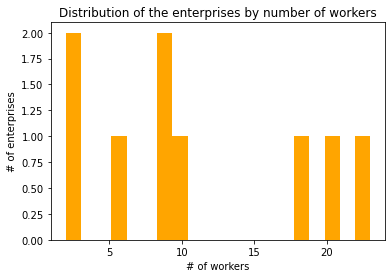

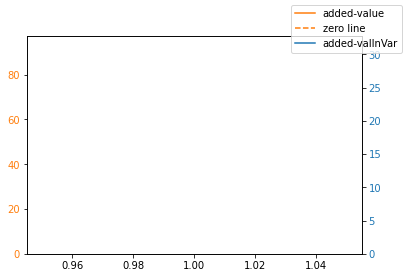

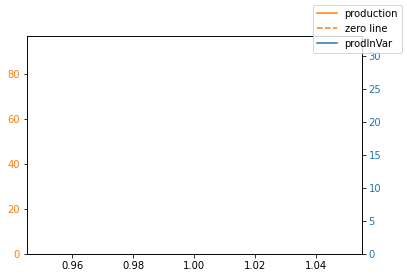

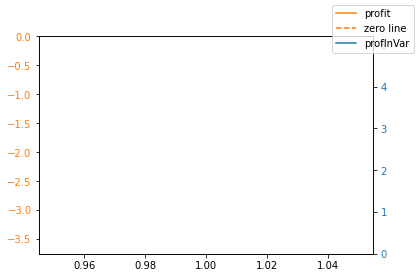

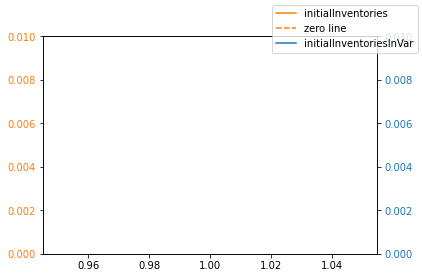

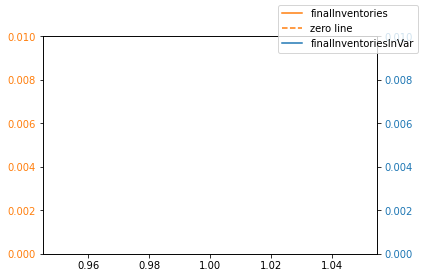

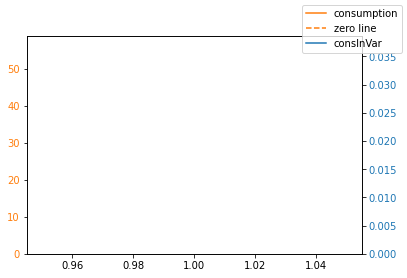

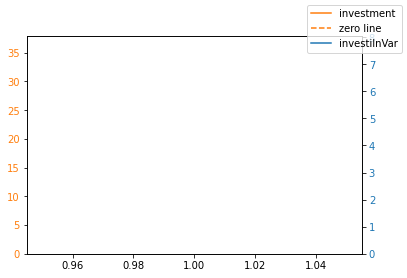

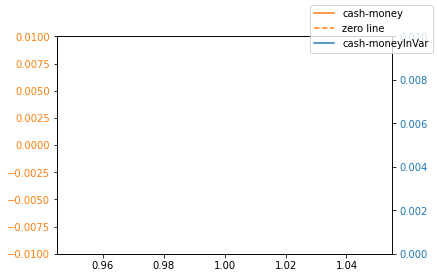

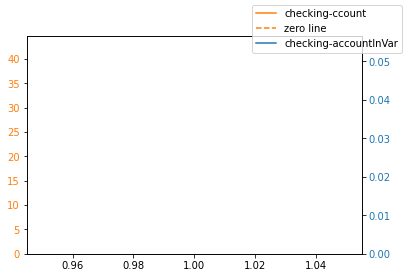

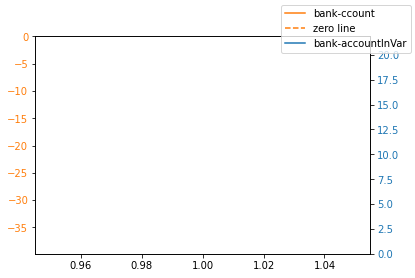

In [8]:
# the seed must be in range -2147483648 to 2147483647
r.seed(12345)

generateSeeds()

setup(r,cmv.functionSeedList[0])

cmv.actionList=["produceAll()","payWagesAll()",\
                "buyConsumptionOrInvestmentGoodsAll(r,cmv.functionSeedList[3])",\
                "computeAndApplyInterestsAll()","makeBalanceSheetAll()",\
                "distributeDividendAll()","accountCashMoneyAll()",\
                "accountCheckingAccountAll()","accountBankAccountAll()",\
                "makeBankFinancialAccountsAll()"\
                ]

for cmv.cycle in range(cmv.ncycles):
    for anAction in cmv.actionList:
            exec(anAction)

makeHist() 

nationalAccounts()

plot([0,max(cmv.totalAddedValueSeries)],cmv.totalAddedValueSeries,"added-value",\
     [0, max(cmv.totalAddedValueInfraVarSeries)],cmv.totalAddedValueInfraVarSeries,"added-valInVar")

plot([0,max(cmv.totalProductionSeries)],cmv.totalProductionSeries,"production",\
     [0, max(cmv.totalProductionInfraVarSeries)],cmv.totalProductionInfraVarSeries,"prodInVar")

plot([min(cmv.totalProfitSeries), max(0,max(cmv.totalProfitSeries))],\
     cmv.totalProfitSeries,"profit",\
     [0, max(cmv.totalProfitInfraVarSeries)],cmv.totalProfitInfraVarSeries,"profInVar")

plot([min(cmv.totalInitialInventoriesSeries), max(0.01,max(cmv.totalInitialInventoriesSeries))],\
     cmv.totalInitialInventoriesSeries,"initialInventories",\
     [0, max(0.01,max(cmv.totalInitialInventoriesInfraVarSeries))],\
     cmv.totalInitialInventoriesInfraVarSeries,"initialInventoriesInVar")

plot([min(cmv.totalFinalInventoriesSeries), max(0.01,max(cmv.totalFinalInventoriesSeries))],\
     cmv.totalFinalInventoriesSeries,"finalInventories",\
     [0, max(0.01,max(cmv.totalFinalInventoriesInfraVarSeries))],\
     cmv.totalFinalInventoriesInfraVarSeries,"finalInventoriesInVar")

plot([0, max(cmv.totalConsumptionSeries)],cmv.totalConsumptionSeries,"consumption",\
     [0, max(cmv.totalConsumptionInfraVarSeries)],cmv.totalConsumptionInfraVarSeries,"consInVar")

plot([0, max(cmv.totalInvestmentSeries)],cmv.totalInvestmentSeries,"investment",\
     [0, max(cmv.totalInvestmentInfraVarSeries)],cmv.totalInvestmentInfraVarSeries,"investiInVar")

plot([min(-0.01, min(cmv.totalCashMoneySeries)),max(0.01,max(cmv.totalCashMoneySeries))],\
     cmv.totalCashMoneySeries,"cash-money",\
     [0, max(0.01,max(cmv.totalCashMoneyInfraVarSeries))],cmv.totalCashMoneyInfraVarSeries,"cash-moneyInVar")

plot([min(-0.01, min(cmv.totalCheckingAccountSeries)),max(0.01,max(cmv.totalCheckingAccountSeries))],\
     cmv.totalCheckingAccountSeries,"checking-ccount",\
     [0, max(0.01,max(cmv.totalCheckingAccountInfraVarSeries))],cmv.totalCheckingAccountInfraVarSeries,\
     "checking-accountInVar")

plot([min(-0.01, min(cmv.totalBankAccountSeries)),max(0.01,max(cmv.totalBankAccountSeries))],\
     cmv.totalBankAccountSeries,"bank-ccount",\
     [0, max(0.01,max(cmv.totalBankAccountInfraVarSeries))],cmv.totalBankAccountInfraVarSeries,\
     "bank-accountInVar")


In [9]:
list(cmv.firmList[i].num for i in range(cmv.firmNum))

[55, 76, 85, 31, 33, 35, 97]

In [10]:
list(cmv.entrepreneurList[i].num for i in range(cmv.firmNum))

[37, 11, 33, 31, 97, 85, 35]

In [11]:
# last cycle
tCashNe=0
for anA in cmv.agentList:
    if not anA.entrepreneur: tCashNe+=anA.cashMoney

tCashE=0
for anA in cmv.agentList:
    if anA.entrepreneur: tCashE+=anA.cashMoney

In [12]:
tCashNe

0

In [13]:
tCashE

0

In [14]:
tC=0
for i in range(cmv.ncycles):
    tC+=cmv.totalConsumptionSeries[i]

In [15]:
tC

58.804039463999324

In [16]:
tCE=0
for i in range(cmv.ncycles):
    tCE+=cmv.totalEntrepreneurConsumptionSeries[i]

In [17]:
tCE

5.882037574389951

In [18]:
tCNe=0
for i in range(cmv.ncycles):
    tCNe+=cmv.totalNonEntrepreneurConsumptionSeries[i]

In [19]:
tCNe

52.922001889609376

In [20]:
tI=0
for i in range(cmv.ncycles):
    tI+=cmv.totalInvestmentSeries[i]

In [21]:
tI

37.852278548540326

In [22]:
cmv.totalCheckingAccountSeries

[44.63999405998423]

In [23]:
cmv.totalBankAccountSeries

[-39.84523284610185]

In [24]:
for anItem in cmv.bankList:
    print(len(anItem.myWorkers))

9
9


In [25]:
for anItem in cmv.firmList:
    print(len(anItem.myWorkers))

23
3
20
10
2
18
6


In [26]:
for aBank in cmv.bankList:
    print(aBank.num, list(aBank.myPrivateClients[i].num \
                          for i in range(len(aBank.myPrivateClients))))
    print(aBank.num, list(aBank.myCommercialClients[i].num \
                          for i in range(len(aBank.myCommercialClients))))

37 [1, 3, 5, 8, 9, 11, 14, 16, 18, 20, 21, 23, 24, 25, 28, 30, 31, 34, 36, 37, 39, 40, 41, 42, 44, 46, 47, 49, 50, 51, 52, 53, 54, 56, 59, 60, 62, 65, 66, 68, 70, 71, 73, 74, 76, 77, 78, 81, 83, 85, 87, 88, 89, 90, 92, 93, 95, 99]
37 [33, 31, 97, 85, 55]
11 [2, 4, 6, 7, 10, 12, 13, 15, 17, 19, 22, 26, 27, 29, 32, 33, 35, 38, 43, 45, 48, 55, 57, 58, 61, 63, 64, 67, 69, 72, 75, 79, 80, 82, 84, 86, 91, 94, 96, 97, 98, 100]
11 [35, 76]


In [27]:
for aBank in cmv.bankList:
    print(aBank.num, aBank.myDebtsVsAgents, aBank.myCreditsVsAgents,\
                     aBank.myDebtsVsFirms,  aBank.myCreditsVsFirms)  

37 -27.3517590856842 0 0 -36.53983831922644
11 -17.28823497430003 0 0 -3.3053945268754124


In [28]:
for aBank in cmv.bankList:
    #aBank.computeAndApplyInterests()
    print(aBank.num,aBank.interestOnDeposits,aBank.interestOnLoans)

37 0.2497197319441174 0.3533704886358221
11 0.16613024518356032 0.030181075053796635


In [29]:
cmv.bankList[1].myEntrepreneur in cmv.bankList[1].myPrivateClients

False

In [30]:
len(cmv.bankList[0].myWorkers)

9

In [31]:
cmv.agentList[0].num

1

In [32]:
cmv.bankList[0].r.random()

0.8909551513014097

In [33]:
cmv.bankList[0].myCommercialClients

In [34]:
cmv.bankList[0].myPrivateClientsTotalInterestOnDeposits

0.24582936017644647

In [35]:
cmv.bankList[0].myPrivateClientsTotalInterestOnLoans

0

In [36]:
cmv.bankList[0].myCommercialClientsTotalInterestOnDeposits

0.003890371767670931

In [37]:
cmv.bankList[0].myCommercialClientsTotalInterestOnLoans

0.3533704886358221

In [38]:
list(cmv.firmList[i].addedValue for i in range(cmv.firmNum))

[18.510426571427974,
 3.520796597208925,
 16.592418509564993,
 11.466532609565462,
 2.244430483445347,
 17.763788499006786,
 6.883115404716371]

In [39]:
list(cmv.firmList[i].profit for i in range(cmv.firmNum))

[-4.622543768372461,
 0.5142118928839043,
 -3.5185961726295534,
 1.466532609565462,
 0.19162339159345465,
 -0.25980787172199016,
 0.826537029927422]

In [40]:
list(cmv.bankList[i].addedValue for i in range(cmv.bankNum))

[7.830878114600683, 12.231373158460398]

In [41]:
list(cmv.bankList[i].profit for i in range(cmv.bankNum))

[-1.418841617343435, 3.0652429132768377]

In [42]:
list(cmv.bankList[i].myCommercialClientsTotalInterestOnDeposits for i in range(cmv.bankNum))

[0.003890371767670931, 0]

In [43]:
list(cmv.bankList[i].myPrivateClientsTotalInterestOnDeposits for i in range(cmv.bankNum))

[0.24582936017644647, 0.16613024518356032]

In [44]:
sum(list((cmv.firmList+cmv.bankList)[i].production for i in range(cmv.firmNum+cmv.bankNum)))

96.65631801253964

In [45]:
sum(list((cmv.firmList)[i].interestOnDeposits for i in range(cmv.firmNum)))

0.003890371767670931

In [46]:
sum(list((cmv.bankList)[i].interestOnLoans for i in range(cmv.bankNum)))

0.38355156368961874

In [47]:
sum(list((cmv.firmList+cmv.bankList)[i].production for i in range(cmv.firmNum+cmv.bankNum)))+\
sum(list((cmv.firmList)[i].interestOnDeposits for i in range(cmv.firmNum)))+\
sum(list((cmv.bankList)[i].interestOnLoans for i in range(cmv.bankNum)))

97.04375994799693

In [48]:
sum(list((cmv.agentList)[i].madeConsumption for i in range(cmv.agentNum)))

58.80403946399932

In [49]:
sum(list((cmv.firmList+cmv.bankList)[i].madeInvestment for i in range(cmv.firmNum+cmv.bankNum)))

37.85227854854033

In [50]:
sum(list((cmv.agentList)[i].madeConsumption for i in range(cmv.agentNum)))+\
sum(list((cmv.firmList+cmv.bankList)[i].madeInvestment for i in range(cmv.firmNum+cmv.bankNum)))

96.65631801253966

In [51]:
sum(list((cmv.firmList+cmv.bankList)[i].profit for i in range(cmv.firmNum+cmv.bankNum)))+\
sum(list((cmv.firmList)[i].interestOnLoans for i in range(cmv.firmNum)))+\
sum(list((cmv.bankList)[i].interestOnDeposits for i in range(cmv.bankNum)))+\
sum(list(len((cmv.firmList+cmv.bankList)[i].myWorkers)*cmv.wage for i in range(cmv.firmNum+cmv.bankNum)))

97.04375994799693

In [52]:
sum(list((cmv.firmList+cmv.bankList)[i].salesRevenues for i in range(cmv.firmNum+cmv.bankNum)))

96.65631801253964